# **Proyecto tasación inmuebles para la zona de Manises y alrededores, Valencia.**
---
---

- ### ***¿Qué problema o necesidad vamos a resolver?***

### La necesidad que este proyecto puede cubrir a la inmobiliaria de la zona de Manises **es la tasación inmediata del inmueble a particulares de la zona en la misma visita de la vivienda**.
---

- ### ***¿Qué solución aporta tu modelo de ML?***

### La ***posibilidad de automatizar procesos de burocracia después de la tasación*** es muy alta, y esto puede cubrir aún más la necesidad de la empresa y **optimizar todo el proceso que conlleva** desde la visita al inmueble hasta el pacto de su venta a cargo de la empresa.
---

+ ## *Primeros pasos para obtener datos y poder construir un dataset:*

### Debido a que la empresa no pudo facilitarme información y datos del histórico de viviendas vendidas, opté por utilizar la herramienta **WebScrapping** para *"pedir prestada"* la información de las viviendas a la venta de los siguientes portales:

- #### IDEALISTA.COM    
- #### PISOS.COM
- #### FOTOCASA.COM

**La zona a buscar es en Manises y sus alrededores para cada uno de los portales**

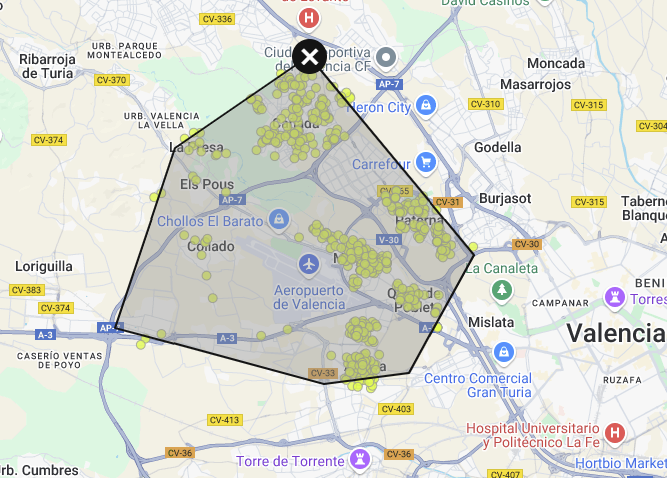

### Empezando por ***webscrapping_html.ipynb***, al **inspeccionar cada página** de los resultados de cada portal, se **guarda el HTML** en un fichero.txt donde luego se **extrae la informacion** con la librería ***Selenium***, resultando en un dataframe para cada portal, ya trabajado para extraer sólo los datos relevantes. 

In [ ]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import os
import re

# Ruta de la carpeta IDEALISTA que contiene el HTML
carpeta = "../data/raw/idealista"

# Lista para almacenar todos los datos de viviendas
datos_todas_viviendas = []

# Iterar sobre todos los archivos .txt de la carpeta
for archivo in os.listdir(carpeta):
    if archivo.endswith(".txt"):
        # Leer el contenido del archivo
        print(archivo)
        ruta_archivo = os.path.join(carpeta, archivo)
        with open(ruta_archivo, 'r', encoding='utf-8') as file:
            html_content = file.read()
        
        # Crear el objeto BeautifulSoup
        soup = bs(html_content, "lxml")
        
        # Buscar el main content
        main_content = soup.select('main.listing-items.core-vitals-listing-map#main-content')
        if not main_content:
            print(f"No se encontró 'main-content' en el archivo: {archivo}")
            continue
        
        # Buscar todos los <div class="item-info-container"> dentro de main_content
        item_info_containers = main_content[0].select('div.item-info-container')
        
        for container in item_info_containers:
            # Agencia
            # agencia = container.select_one('picture.logo-branding a').get('title', '').strip() if container.select_one('picture.logo-branding a') else None
            
            # Título, calle y barrio
            enlace_vivienda = container.select_one('a.item-link')
            titulo = enlace_vivienda.get_text(strip=True) if enlace_vivienda else None
            title_attr = enlace_vivienda.get('title', '') if enlace_vivienda else ''

            # Extraer calle y barrio del título
            if ',' in title_attr:  # Si hay comas en el título
                partes = [parte.strip() for parte in title_attr.split(',')]  # Dividir por comas y eliminar espacios
                calle = partes[0] if len(partes) > 0 else None  # La primera parte es la calle
                municipio = partes[-1] if len(partes) > 0 else None # El último elemento es el municipio
                barrio = partes[-2] if len(partes) > 1 else None  # El penúltimo elemento es el barrio
            else:  # Si no hay comas
                palabras = title_attr.split()  # Dividir el título por espacios
                if len(palabras) > 2:  # Si hay más de dos palabras
                    calle = ' '.join(palabras[:-2])  # Todo excepto las dos últimas palabras como calle
                    barrio = ' '.join(palabras[-2:])  # Las dos últimas palabras como barrio
                    municipio = "Manises"
                else:  # Si hay dos palabras o menos
                    calle = None  # No hay suficiente información para la calle
                    barrio = ' '.join(palabras)  # Tomar todo como barrio
                    municipio = "Manises"
                    
            # Precio
            precio = container.select_one('div.price-row span.item-price').get_text(strip=True) if container.select_one('div.price-row span.item-price') else None
            precio = re.sub(r'[^\d]', '', precio) if precio else None  # Eliminar caracteres no numéricos
            
            # Habitaciones, metros cuadrados y planta
            detalles = container.select('div.item-detail-char span.item-detail')
            habitaciones = re.sub(r'[^\d]', '', detalles[0].get_text(strip=True)) if len(detalles) > 0 else None
            metros_cuadrados = re.sub(r'[^\d]', '', detalles[1].get_text(strip=True)) if len(detalles) > 1 else None
            planta = None
            for detalle in detalles:
                texto = detalle.get_text(strip=True)
                if "hab" in texto:
                    habitaciones = re.sub(r'[^\d]', '', texto)
                elif "m²" in texto:
                    metros_cuadrados = re.sub(r'[^\d]', '', texto)
                elif "Planta" in texto:
                    planta = texto

            # Tipo Vivienda
            if 'piso' in title_attr.lower():
                tipo_vivienda = 'Piso'
            elif 'casa' in title_attr.lower() and metros_cuadrados and float(metros_cuadrados) <= 100:
                tipo_vivienda = 'Casa'
            elif ('casa' in title_attr.lower() or 'chalet' in title_attr.lower()) and metros_cuadrados and float(metros_cuadrados) > 100:
                tipo_vivienda = 'Chalet'
            else:
                tipo_vivienda = None

            # Descripción
            descripcion_elemento = container.select_one('div.item-description p.ellipsis')
            descripcion = descripcion_elemento.get_text(strip=True) if descripcion_elemento else None
            
            # Número de baños (buscar "baños" en la descripción)
            numero_baños = None
            if descripcion:
                match = re.search(r'(\d+)\s*baños?', descripcion)
                numero_baños = match.group(1) if match else None

            elif descripcion and numero_baños is None:
                # Busca expresiones como "1 baño", "2 baños", "baño individual", etc.
                match = re.search(r'(\d+)\s*(?:baño|baños?|aseos?|wc)', descripcion, re.IGNORECASE)
                numero_baños = match.group(1) if match else None
            
            # Etiquetas
            etiquetas = [tag.get_text(strip=True) for tag in container.select('div.listing-tags-container span.listing-tags')]
            
            # Garaje incluido
            garaje = "Sí" if container.select_one('div.price-row span.item-parking') else "No"

            # Almacenar los datos en un diccionario
            datos_vivienda = {
                'calle': calle,
                'barrio': barrio,
                'municipio': municipio,
                'tipo_vivienda': tipo_vivienda,
                'titulo': titulo,
                'habitaciones': habitaciones,
                'metros_cuadrados': metros_cuadrados,
                'aseos': numero_baños,
                'planta': planta,
                'descripcion': descripcion,
                'etiquetas': etiquetas,
                'garaje': garaje,
                'precio': precio
            }
            datos_todas_viviendas.append(datos_vivienda)

# Crear un DataFrame consolidado
ideal = pd.DataFrame(datos_todas_viviendas)

# Convertir las columnas a tipo numérico
ideal['precio'] = ideal['precio'].astype(str).str.replace(r'[^\d]', '', regex=True)  # Eliminar caracteres no numéricos
ideal['precio'] = pd.to_numeric(ideal['precio'], errors='coerce') 
ideal['habitaciones'] = pd.to_numeric(ideal['habitaciones'], errors='coerce')
ideal['metros_cuadrados'] = pd.to_numeric(ideal['metros_cuadrados'], errors='coerce')
ideal['aseos'] = pd.to_numeric(ideal['aseos'], errors='coerce')

print(ideal.shape)
ideal.head(2)

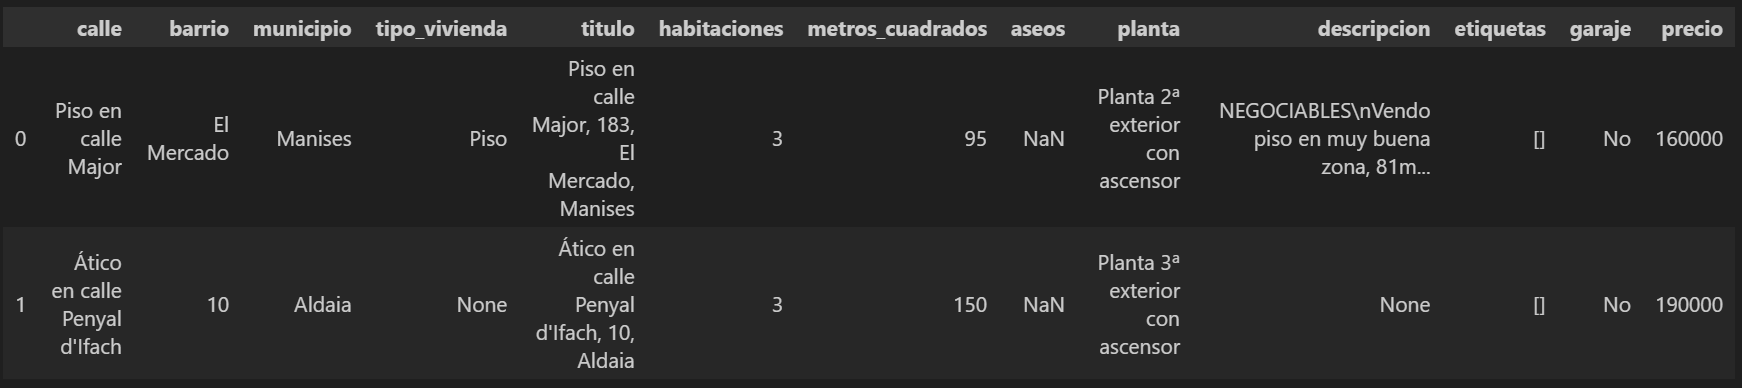

### Asi para cada portal, **exportando cada dataframe en un CSV** para posteriormente en el notebook ***featuring_enginnering.ipynb*** se terminan concatenando todos para tener un **dataframe general y ya poder trabajar los datos.**

***Dataframe definitivo.csv*** en ***featuring_enginnering.ipynb***

In [ ]:
# <class 'pandas.core.frame.DataFrame'>
# RangeIndex: 1211 entries, 0 to 1210
# Data columns (total 13 columns):
#  #   Column            Non-Null Count  Dtype  
# ---  ------            --------------  -----  
#  0   calle             1211 non-null   object 
#  1   barrio            1211 non-null   object 
#  2   municipio         1127 non-null   object 
#  3   tipo_vivienda     1147 non-null   object 
#  4   titulo            1211 non-null   object 
#  5   habitaciones      1119 non-null   float64
#  6   metros_cuadrados  1210 non-null   float64
#  7   aseos             631 non-null    float64
#  8   planta            459 non-null    object 
#  9   descripcion       1193 non-null   object 
#  10  etiquetas         1211 non-null   object 
#  11  garaje            1211 non-null   object 
#  12  precio            1206 non-null   float64
# dtypes: float64(4), object(9)
# memory usage: 123.1+ KB

### Comenzando por la columna **"barrio"**, se explora y **se extrae la información** para obtener valores únicos de los barrios de las viviendas Scrappeadas y **determinar si se trata de una zona centrica** o no, y a raiz de ellos se creará una **nueva columna** numerica llamada **"zona_centro" donde tendrá 0 o 1** según.

In [ ]:
# zona_centro
# 0    930
# 1    281
# Name: count, dtype: int64

### Para la columna **"Municipio" limpiamos y tranformamos los datos para obtener valores únicos** y para los datos NaN donde no podemos extraer de dónde son, le asignamos a "Otros"

In [ ]:
# df['municipio'] = df["municipio"].fillna('Otro') # De momento asignamos "Otro" a los valores NaN
# df['municipio'].value_counts()

# municipio
# Manises               658
# Paterna               397
# Otro                   84
# Aldaia                 43
# Quart de Poblet        24
# Riba-Roja de Túria      5
# Name: count, dtype: int64

### En la columna **"tipo_vivienda"** haremos lo mismo, **limpiar y transformar** para tener sólo valores únicos pero en este caso **para dar valor a los NaN, buscaremos su informacion en la columa "calle"**, donde puede nombrar el tipo como: Dúplex, Estudio, Piso...

In [ ]:
def ajuste_manual_tipovivienda(texto):
    # Para definir si es PISO
    if "piso" in texto.lower():
        texto = "Piso"
    elif "atico" in texto.lower() or "ático" in texto.lower():
        texto = "Piso"
    elif "duplex" in texto.lower() or "dúplex" in texto.lower():
        texto = "Piso"
    # Para definir si es CHALET 
    elif "chalet" in texto.lower():
        texto = "Chalet"
    # Para definir si es CASA 
    elif "casa" in texto.lower():
        texto = "Casa"
    # Para definir si es PLANTA BAJA 
    elif "planta" in texto.lower():
        texto = "Planta baja"
    # Para definir si es CASA ADOSADA 
    elif "adosada" in texto.lower():
        texto = "Casa adosada"
    # Para definir si es FINCA 
    elif "finca" in texto.lower() or "cortijo" in texto.lower():
        texto = "Finca"
    # Para definir si es ESTUDIO 
    elif "estudio" in texto.lower() or "loft" in texto.lower():
        texto = "Estudio"
    # Si no es ninguna de la anteriores, se asignará la más común.
    else:
        texto = "Piso"

    return texto

# # Filas con NaN en "tipo_vivienda"
# mask_nan = df["tipo_vivienda"].isna()

## Aplicar la función solo a las filas con NaN
# df.loc[mask_nan, "tipo_vivienda"] = df.loc[mask_nan, "calle"].apply(ajuste_manual_tipovivienda)
# print("Valores NaN:", df["tipo_vivienda"].isna().sum()) # Comprobamos si existen valores NaN
# df["tipo_vivienda"].value_counts()

# tipo_vivienda
# Piso            710
# Chalet          356
# Casa            102
# Casa adosada     17
# Planta baja      11
# Finca            10
# Estudio           5
# Name: count, dtype: int64

### En la siguiente columna, **"Habitaciones"** mas de lo mismo con los NaN, **extraemos la info de la columna "Descripción" y despues limpiamos** los valores atípicos que pueda quedar *(ej: 74 habitaciones*)

In [ ]:
# habitaciones
# 3.0     453
# 4.0     288
# 2.0     166
# 5.0     104
# 6.0      50
# 1.0      46
# 7.0      10
# 8.0       4
# 10.0      2
# 9.0       2
# 11.0      1
# Name: count, dtype: int64

### Para algunos de los NaN que no hemos podido rescatar hemos aplicado **SimpleImputer('con la mediana redondeada')**

In [ ]:
# Tipo de vivienda: 'Casa' | Mediana calculada: 4.0 | Truncada: 4
# Tipo de vivienda: 'Casa adosada' | Mediana calculada: 4.0 | Truncada: 4
# Tipo de vivienda: 'Chalet' | Mediana calculada: 4.0 | Truncada: 4
# Tipo de vivienda: 'Estudio' | Mediana calculada: 1.0 | Truncada: 1
# Tipo de vivienda: 'Piso' | Mediana calculada: 3.0 | Truncada: 3
# Tipo de vivienda: 'Planta baja' | Mediana calculada: 2.0 | Truncada: 2
# Valores NaN: 0

### Observamos el resultado de la columna **"metros_cuadrados"**
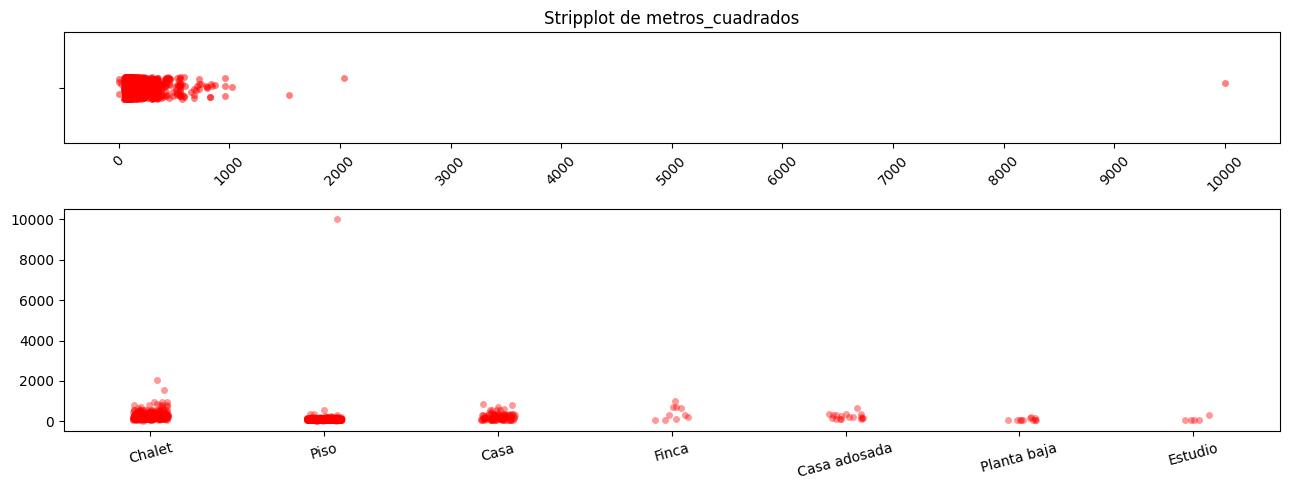

### Existen algunos valores (outliers) muy elevados y pueden darnos problemas. Si los visualizamos, veremos que son poquitos.


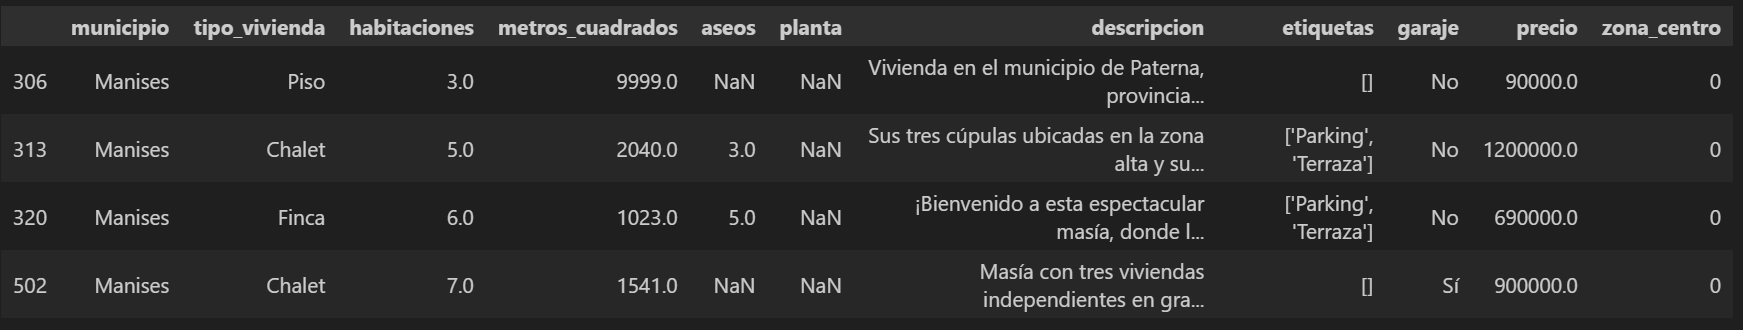

### Podemos ver los **outliers a partir de los 1000 m2**, en especial el de 9999 m2, y esto **generará problemas** para el modelo, por lo que vamos a **eliminar** todas las filas que contengan un valor **superior a los 1000 m2**.

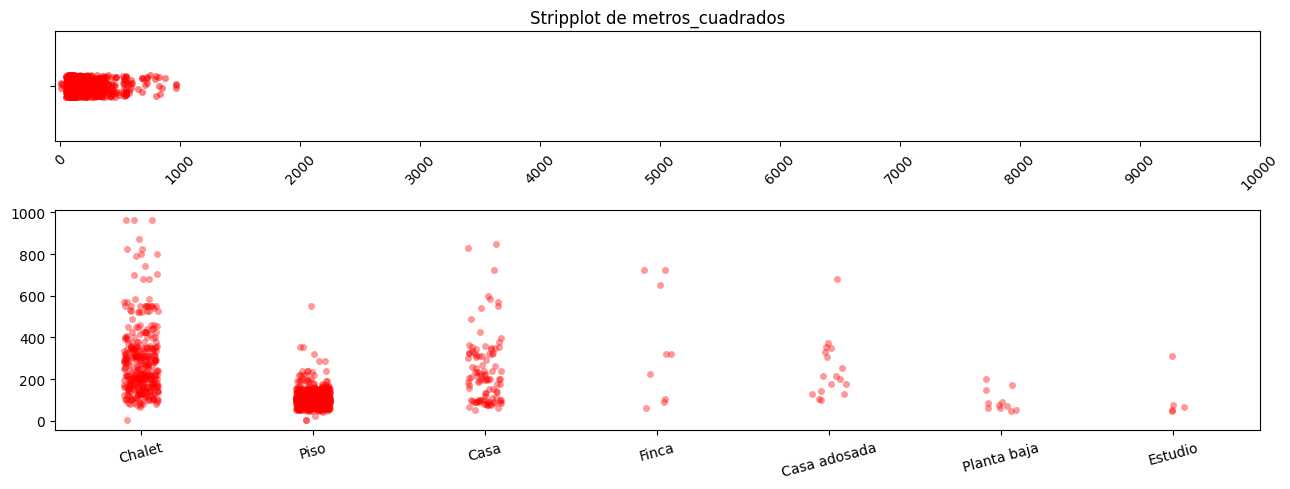

### Continuamos ahora con la columna **"aseos"** donde utilizaremos la columna **'Descripción'** para ver si podemos extraer información, ya que esta tambien tiene y muchos valores NaNs.

In [ ]:
# Valores NaN: 475

# aseos
# 2.0      322
# 1.0      246
# 3.0      101
# 4.0       48
# 5.0        4
# 11.0       2
# 300.0      2
# 6.0        2
# 30.0       1
# 65.0       1
# 16.0       1
# 70.0       1
# Name: count, dtype: int64

### Y para los valores descomunales como 65, 300, 30, 70 aseos... vamos a tratarlos ya que ha tenido que haber un error. **Utilizaremos la misma operacion** anterior pero afectando sólo a los valores de **aseos mayores que 11**. ### Y para los NaN, vamos a aplicarles **SimpleImputer('con la *mediana* redondeada')** de aseos **según el "tipo de vivienda"** al que pertenezca.

In [ ]:
# Tipo de vivienda: 'Casa' | Mediana calculada: 2.0 | Truncada: 2
# Tipo de vivienda: 'Casa adosada' | Mediana calculada: 2.0 | Truncada: 2
# Tipo de vivienda: 'Chalet' | Mediana calculada: 2.0 | Truncada: 2
# Tipo de vivienda: 'Estudio' | Mediana calculada: 1.5 | Truncada: 1
# Tipo de vivienda: 'Finca' | Mediana calculada: 2.0 | Truncada: 2
# Tipo de vivienda: 'Piso' | Mediana calculada: 2.0 | Truncada: 2
# Tipo de vivienda: 'Planta baja' | Mediana calculada: 1.0 | Truncada: 1

# Valores NaN: 0

# aseos
# 2.0     794
# 1.0     255
# 3.0     101
# 4.0      48
# 5.0       4
# 11.0      2
# 6.0       2
# Name: count, dtype: int64

### Haremos lo mismo para la columna **"planta"**, pero antes hay que limpiar los datos para tenerlos en ***float***

In [ ]:
# Valores NaN: 747

# planta
# 2ª planta                           35
# 1ª planta                           35
# Planta 3ª exterior con ascensor     32
# Planta 1ª exterior con ascensor     31
# Planta 2ª exterior con ascensor     28
# 3ª Planta                           23
# ...

### La siguiente función **extrae el valor numérico** de cada fila y lo asigna como nuevo valor

In [ ]:
def extraer_numero_planta(texto):
    if isinstance(texto, str):
        match = re.search(r'(\d+)', texto)  # Busca el primer número
        if match:
            return int(match.group(1))  # Retornar el número como entero
    return None

df['planta'] = df['planta'].apply(extraer_numero_planta)

print("Valores NaN:", df['planta'].isna().sum()) # Mostrará el num de NaNs existentes en la columna
df["planta"].value_counts()

# planta
# 1.0     112
# 2.0      99
# 3.0      88
# 4.0      72
# 5.0      50
# 6.0      14
# 7.0       8
# 8.0       6
# 9.0       5
# 10.0      4
# 15.0      1
# Name: count, dtype: int64

### Para los NaN de la columna, vamos a aplicarles nuevamente **SimpleImputer** con la ***mediana*** de planta **según el "tipo de vivienda"**.

In [ ]:
# Tipo de vivienda: 'Casa' | Mediana calculada: 4.0 | Truncada: 4
# Asignado a planta 0 por ser tipo 'Casa adosada'
# Asignado a planta 0 por ser tipo 'Chalet'
# Tipo de vivienda: 'Estudio' | Mediana calculada: 2.0 | Truncada: 2
# Asignado a planta 0 por ser tipo 'Finca'
# Tipo de vivienda: 'Piso' | Mediana calculada: 3.0 | Truncada: 3
# Asignado a planta 0 por ser tipo 'Planta baja'

# Valores NaN en 'planta': 0

# planta
# 0.0     391
# 3.0     342
# 4.0     172
# 1.0     112
# 2.0     101
# 5.0      50
# 6.0      14
# 7.0       8
# 8.0       6
# 9.0       5
# 10.0      4
# 15.0      1
# Name: count, dtype: int64

### Genial, continuamos con la columna **"etiquetas"**, (saltandonos la de **descripción** que sólo la queremos de machaca de la información)

In [ ]:
# etiquetas
# []                                              539
# ['Piso']                                        220
# ['Parking', 'Terraza']                           68
# ['Casa']                                         59
# ['Chalet']                                       56
# ['Ascensor']                                     53
# ['Villa']                                        35
# ['Terraza']                                      20

### Vemos que son todo **str** aunque parecieran listas, asi que vamos a **eliminar los caracteres de "[" y "]"** con el método **.replace()**

In [ ]:
# Aplicar replace a cada elemento de la columna
df["etiquetas"] = df["etiquetas"].apply(lambda x: x.replace("[", "").replace("]", "").replace("'", "") if isinstance(x, str) else x)
df["etiquetas"].value_counts()

# etiquetas
#                                         539
# Piso                                    220
# Parking, Terraza                         68
# Casa                                     59
# Chalet                                   56
# Ascensor                                 53
# Villa                                    35
# Terraza                                  20

### Una vez listos para tratar, aplicamos ***get_dummies*** para convertir en columnas nuevas los valores que nos puedan ser relevantes.

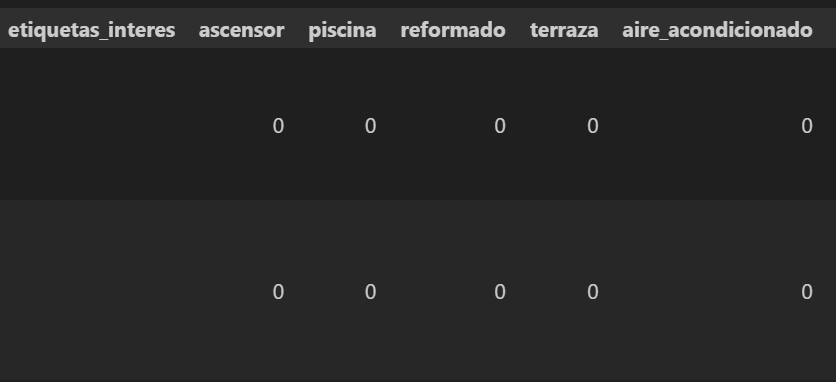

### Genial, una vez tenemos la etiquetas más relevantes desglosadas, ya podemos **eliminar las columnas de "descripción", "etiquetas" y "etiquetas_interes"**

In [ ]:
# <class 'pandas.core.frame.DataFrame'>
# Index: 1206 entries, 0 to 1209
# Data columns (total 14 columns):
#  #   Column              Non-Null Count  Dtype  
# ---  ------              --------------  -----  
#  0   municipio           1206 non-null   object 
#  1   tipo_vivienda       1206 non-null   object 
#  2   habitaciones        1206 non-null   float64
#  3   metros_cuadrados    1206 non-null   float64
#  4   aseos               1206 non-null   float64
#  5   planta              1206 non-null   float64
#  6   garaje              1206 non-null   object 
#  7   zona_centro         1206 non-null   int64  
#  8   ascensor            1206 non-null   int64  
#  9   piscina             1206 non-null   int64  
#  10  reformado           1206 non-null   int64  
#  11  terraza             1206 non-null   int64  
#  12  aire_acondicionado  1206 non-null   int64  
#  13  precio              1201 non-null   float64
# dtypes: float64(5), int64(6), object(3)
# memory usage: 173.6+ KB

### **Para finalizar** debemos convertir las columnas "object" en numericas, ya sea int o float. Por lo que vamos a emplear la ***herramienta de codificación*** **LabelEncoder()**. **Importante guardar las codificaciones** para posteriormente utilizarlas de nuevo en las futuras predicciones.

In [ ]:
# Mapeos y LabelEncoders guardados correctamente como:
# "mapeos.pkl" y "label_encoders.pkl"

# municipio: {'Aldaia': np.int64(0), 'Manises': np.int64(1), 'Otro': np.int64(2), 'Paterna': np.int64(3), 'Quart de Poblet': np.int64(4), 'Riba-Roja de Túria': np.int64(5)}


# tipo_vivienda: {'Casa': np.int64(0), 'Casa adosada': np.int64(1), 'Chalet': np.int64(2), 'Estudio': np.int64(3), 'Finca': np.int64(4), 'Piso': np.int64(5), 'Planta baja': np.int64(6)}


# garaje: {'No': np.int64(0), 'Sí': np.int64(1)}

### LISTO! Ahora comprobamos que no tenemos ***valores repetidos*** y ***exportamos a un CSV*** para comenzar con el **entrenamiento el modelo!**

In [ ]:
print(f"Antes de eliminar duplicados: {df.shape}")
# Nos basamos en las features más importantes de la vivienda para comprobar duplicados:
df = df.drop_duplicates(subset=['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados', 'aseos', 'planta', 'zona_centro', 'precio'])
print(f"Después de eliminar duplicados: {df.shape}")

# Antes de eliminar duplicados: (1201, 14)
# Después de eliminar duplicados: (1113, 14)

df.to_csv("../data/definitivo.csv", index=0)

---
---

## Para cada uno de los modelos **se realizarán pruebas con y sin limitar la columna "precio"** ya que hay algun outlier y algunos otros valores que **superan el millón de euros** y quizas no ayude al modelo. Por lo que **dicho código estará presente en cada modelo** por si fuera necesario.

**Límite superior definitivo a filtrar: 999996.605**

**Cantidad de outliers detectados ajustados: 42**

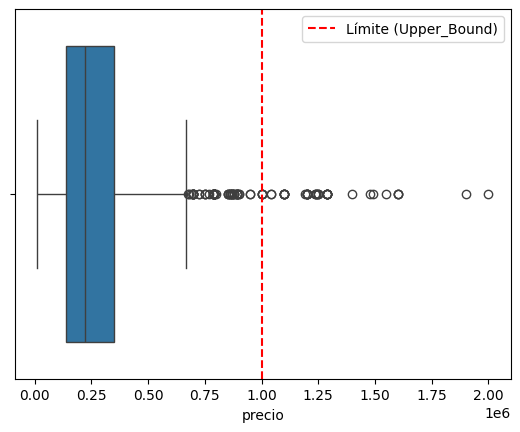

**En cada caso se podrá modificar el rango a limitar**

### Al igual que para cada notebook de modelos estará presente la carga del **"definitivo.csv", el df.describe() y df.heatmap()**. Tambien visualizaremos un **histplot del target "precio"**

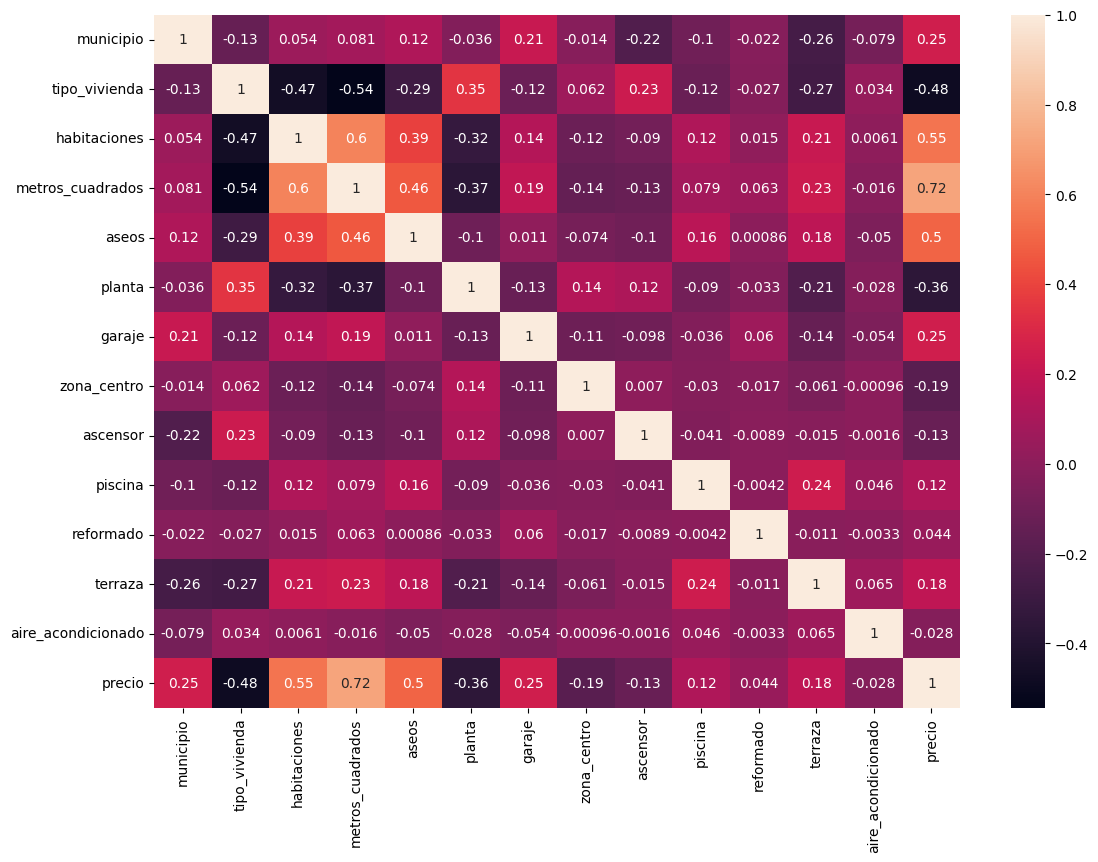

### Las **métricas** principales serán: 
- ### **MAE**(Mean Absolute Error): Mide el error promedio absoluto entre las predicciones y los valores reales.
- ### **MAPE**: (Mean Absolute Percent Error) mide el promedio del error en porcentaje. Es calculado como el promedio en porcentaje de los errores absolutos.
- ### **R2**: Proporción de la varianza explicada por el modelo. 

---

- ### ***¿Qué modelos has probado?***

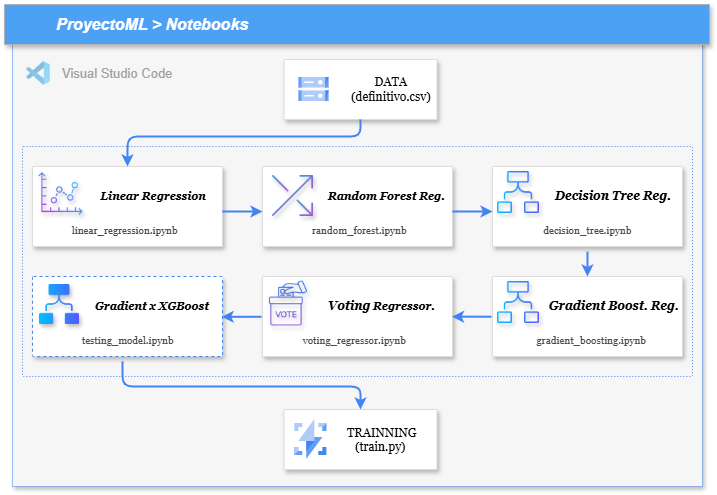

---

- ### ***¿Qué resultados y conclusiones has obtenido?***

### Despues de probar y testear algunos modelos, el que dió **buenas métricas** fué con **GradientBoostingRegressor()**, por lo que decidí probar la herramienta de **VotingRegressor()** para combinarlo con otros modelos.

In [ ]:
''' Las columnas de las features (X), descartamos: 'piscina', 'ascensor', 'reformado' '''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'terraza', 'aire_acondicionado']]

y = df["precio"]  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NORMALIZAMOS

# Creo el scaler con los datos de train
scaler_ultimo = StandardScaler() # Z-score

scaler_ultimo.fit(X_train) # Lo "entreno". Calculo su media y std para cada feature solo en el conjunto de entrenamiento.
'''Los targets (y_train) no deben escalarse en este contexto porque no son características, son valores a predecir.'''

X_train = scaler_ultimo.transform(X_train) # Aplico el scaler y sobreescribo los datos de train
print("X_train", X_train[0],"\n") # Se muestra la primera fila de ejemplo para ver la normalización

# Aplico el mismo scaler con los datos de test
X_test = scaler_ultimo.transform(X_test)
print("X_test", X_test[0],"\n")

# print("Total shape:", X.shape)
# print("Train features shape (X):", X_train.shape)
# print("Train target shape (y):", y_train.shape)
# print("Test features shape (X):", X_test.shape)
# print("Test target shape (y):", y_test.shape)
# print()

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define los modelos base
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Define el VotingRegressor
voting_regressor_ultimo = VotingRegressor(estimators=[
    ('gbr', gbr),
    ('xgb', xgb)
], weights=[0.2, 1])

# Entrena el modelo
voting_regressor_ultimo.fit(X_train, y_train)

# Predicciones
y_pred = voting_regressor_ultimo.predict(X_test)

print(gbr, "\n")
print(xgb, "\n")

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

# METRICAS SIN LA NORMALIZACIÓN
## MAE: 57254.881733606686
## MAPE: 0.3299150682002329
## RMSE: 79887.35412765635
## R2: 0.8039478779275562

### Ahí es donde se obtienen **las mejores métricas, con GradientBoostingRegressor() y XGBoost()** con los ajustes de:
- ### **SIN OUTLIERS** (hasta 1M),
- ### **CON NORMALIZACIÓN**,
- ### **SIN HIPERPARÁMETROS**, 
- ### **QUITANDO** las columnas: ***'piscina', 'ascensor', 'reformado'***,
- ### **CON PESOS [0.2, 1]** para los modelos:

## **Con base en la estadistica del target** (df["precio"].describe()):

- ### **MAE (57,174.55)**: El modelo, en promedio, **tiene un error absoluto de alrededor de 57,174 euros** al predecir el precio de una vivienda. Dado que el precio **promedio** de una vivienda **es de 264,474.43 euros**, esto **equivale a un error absoluto promedio de 21.6%** del valor medio.

- ### **MAPE (0.3293)**: El modelo tiene un **error porcentual promedio del 32.99% respecto al valor real.** Esto puede ser más relevante para viviendas más económicas, donde el impacto del error relativo es mayor.

- ### **MSE (79,853.99)**: Es una **métrica más sensible** a los grandes errores (outliers). En comparación con el rango de precios (mínimo de 11,800 y máximo de 950,000), este valor indica que **el modelo puede manejar tanto valores altos como bajos con un error razonable.**

- ### **R2 (0.8041)**: El modelo **explica el 80.41% de la variabilidad en los precios** de las viviendas. Esto indica un **buen ajuste, pero aún hay margen de mejora** en la captura de ciertas variabilidades (quizás por factores no considerados).

## **Guardamos y exportamos** este último modelo.
### Al igual que el **StandardScaler()**, porque **hubo normalización** para este modelo.

In [ ]:
import joblib

# Exporta el modelo entrenado
joblib.dump(voting_regressor_ultimo, "Gradient_XGB_model.pkl")
print("Modelo exportado como 'Gradient_XGB_model.pkl'")

# Exporta la normalización empleada
joblib.dump(scaler_ultimo, 'scaler_voting.pkl')

---

- ### ***¿Cuáles han sido las variables de mayor impacto?***

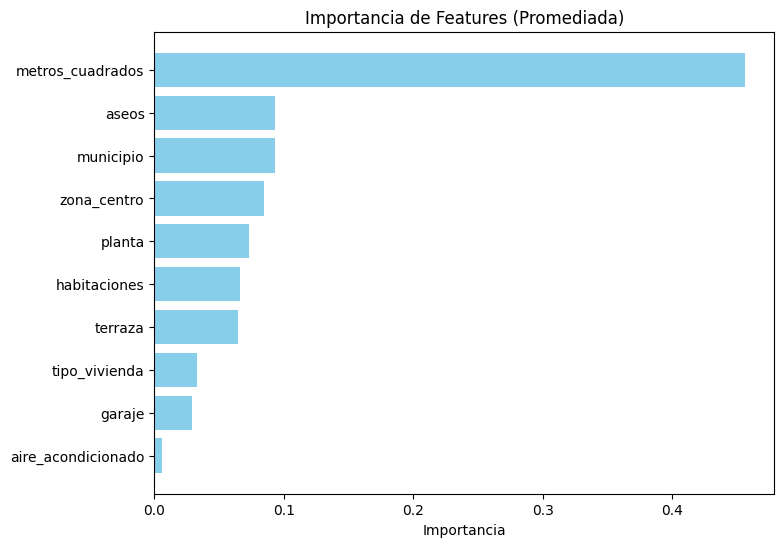

### Aunque, sobre las features importantes se realizan las siguientes observaciones, que **se tendrán en cuenta a la hora de mejorar el modelo** y requerir una mayor precisión, pero **de momento crearemos la aplicacion Streamlit y probaremos tasaciones con la versión actual.**

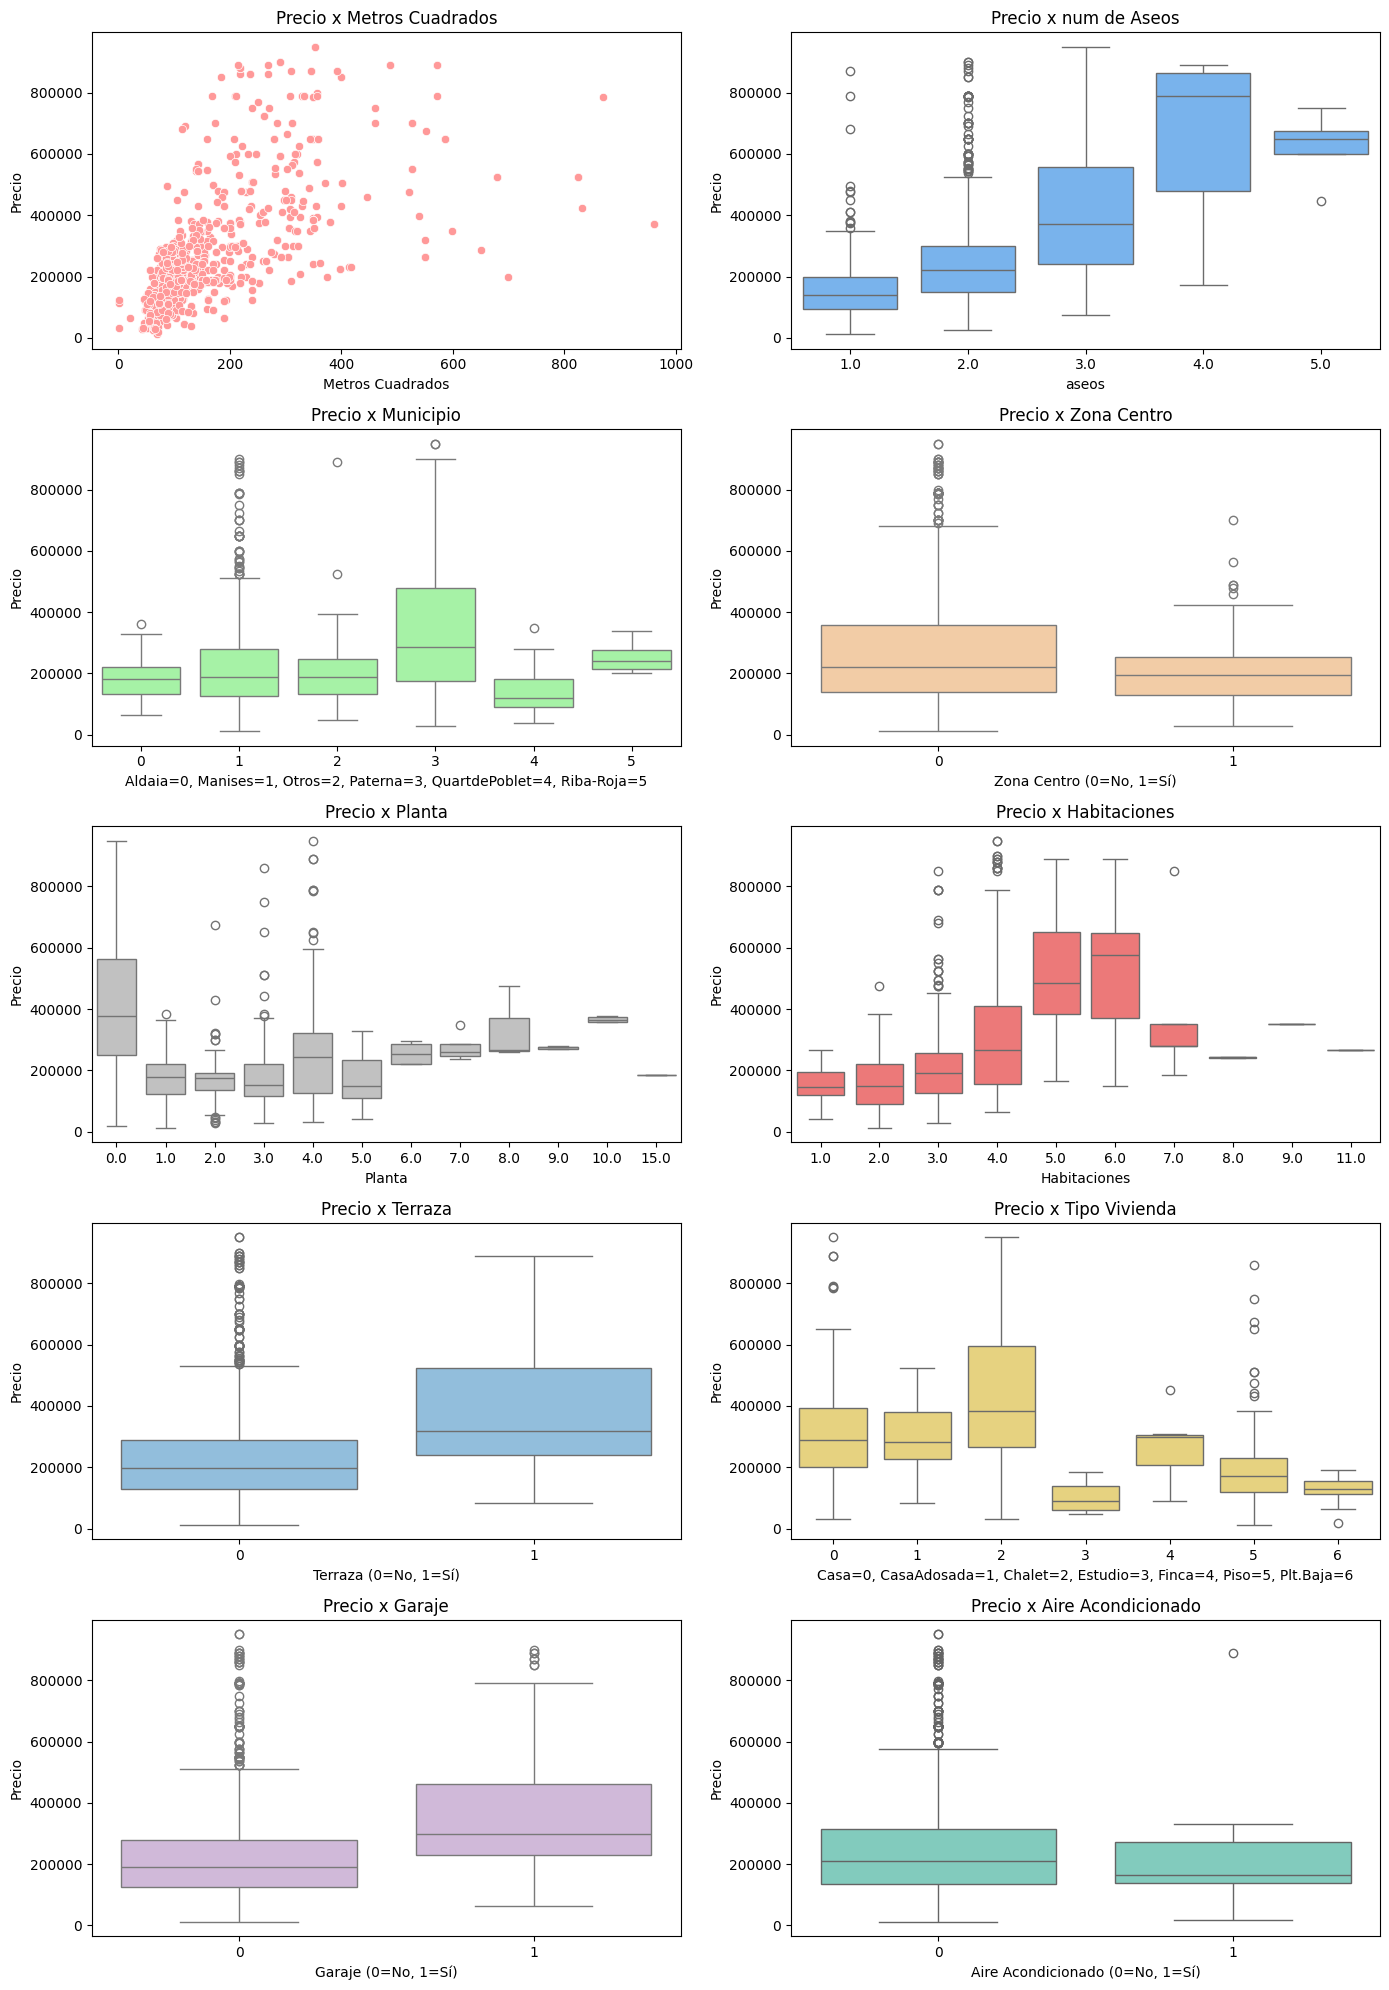

### Observaciones:
- #### **M2**: No es precisamente lineal...
- #### **Zona_centro**: No tiene mucho sentido ya que, en la **zona céntrica hay tipos de viviendas generalmente más baratos** que **en las afueras**, donde hay ***Chalets, Fincas y Casas Adosadas***
- #### **Planta**: La **planta 0** son ***Chalets, Fincas, Casas y Casas Adosadas*** y éstas de normal tienen **precios más elevados.**
- #### **Habitaciones**: Algo lineal pero, **¿Qué ocurre a partir de la 6º habitación?**
- #### **Aire Acondicionado**: No tiene mucho sentido, es irrelevante, por lo que podría descartarse

### Vemos algunas agrupaciones para entender relaciones de las features observadas.

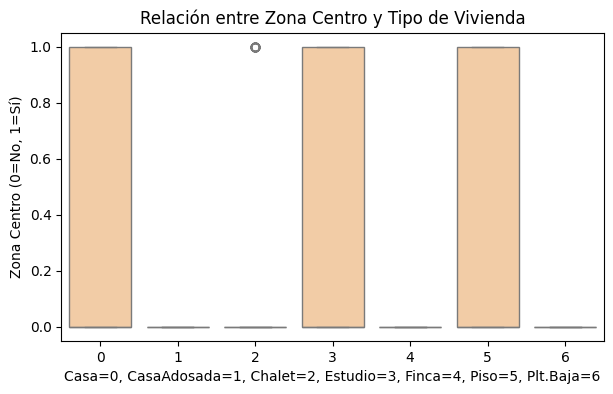

### Se ve claramente que las únicas viviendas que pueden considerarse en zona centro son: **Casa, Estudio y Piso**

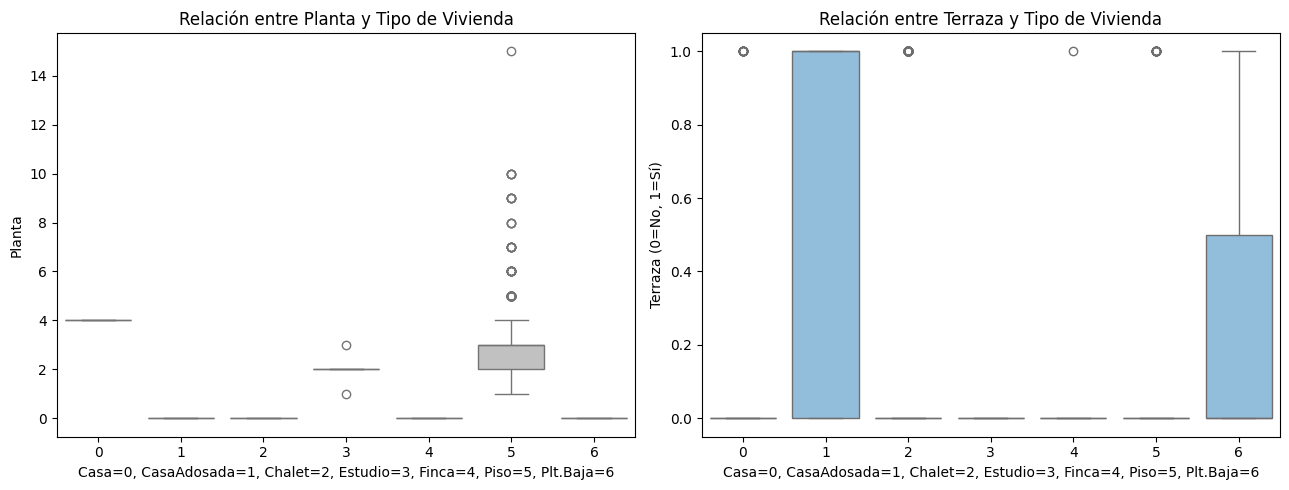

### Puede que "Casa" con altura 4 sea atípico, pero las **únicas viviendas que sí tienen altura son Estudio y Piso**

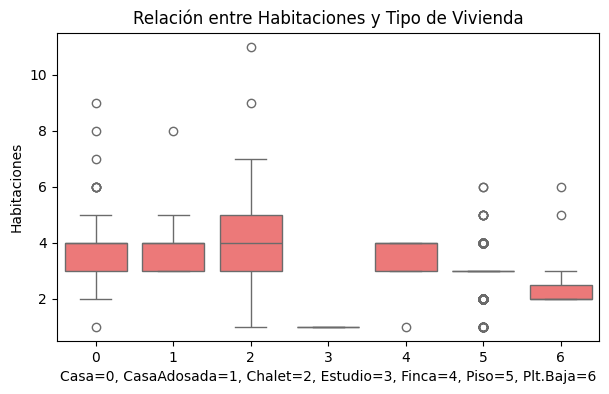

### Parece que entre "Casa" y "Casa Adosada" hay pique, aunque "Casa" muestra mayor numero de habitaciones, pero puede haber algun error ya que anteriormente vimos respecto al precio que a partir de 6 habitaciones el precio disminuye...

### "Estudio" la que menos tiene, "Finca" por el estilo de las "Casas" y "Chalet", "Piso" parece que bien, pero "Plt.Baja" me extraña un poco... Quizás se ha colado alguna "Casa" como "Plt.Baja".

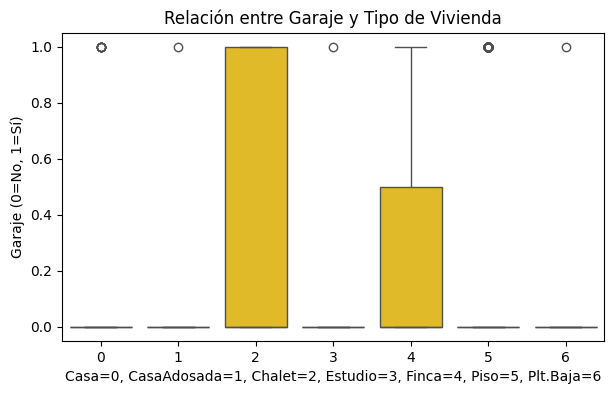

### Estas observaciones se tienen en cuenta para ir mejorando al modelo proximamente y terminar desplegando en la nube a manos de la empresa.

### En **train.py estará el codigo del modelo seleccionado** para testearlo y reentrenarlo y en **app.py** está disponible la aplicacion con Streamlit donde **se podrán testear las predicciones del precio de los inmuebles.**

---

- ¿Qué decisiones o acciones te permiten llevar a cabo tu modelo? ¿Qué consecuencias tiene en negocio? Muy importante

---

### Presentación disponible con Gamma:

https://gamma.app/docs/Tasacion-Automatica-de-Viviendas-para-FuturCasa-62nqt7sw22z685w